In [152]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [269]:
from fsd_path_planning.demo.streamlit_demo.common import get_cones_for_configuration
import numpy as np
import matplotlib.pyplot as plt
from fsd_path_planning.utils.math_utils import rotate, angle_from_2d_vector
from numpy import array, float64

In [270]:
position, direction, cones = get_cones_for_configuration("Hairpin Extreme", do_shuffle=True)

# position = np.array([36, 30.0])

from pathlib import Path
position, direction, cones = eval(Path('/home/papalotis/repos/fsd-path-planning/example_data.txt').read_text())

cones = [np.array(cone).reshape(-1,2) for cone in cones]

In [271]:
cones_together = np.row_stack(cones)

idxs = np.random.default_rng(0).random(len(cones_together)).argsort()


cones_together = cones_together[idxs]

(-4.8480041475, 68.7832457975, -29.923163925, 39.400671425000006)

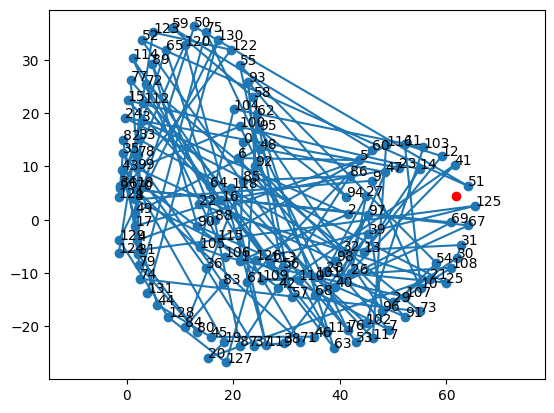

In [272]:

mask_keep = np.ones(len(cones_together), dtype=bool)
# mask_keep[1] = False

cones_together = cones_together[mask_keep]
plt.plot(*cones_together.T, "o-")
plt.plot(*position, "ro")
for i, (x,y) in enumerate(cones_together):
    plt.text(x, y, str(i))

plt.axis("equal")

(-50.240085559916196, 23.89362105191442, -66.71539009820951, 6.192444126128384)

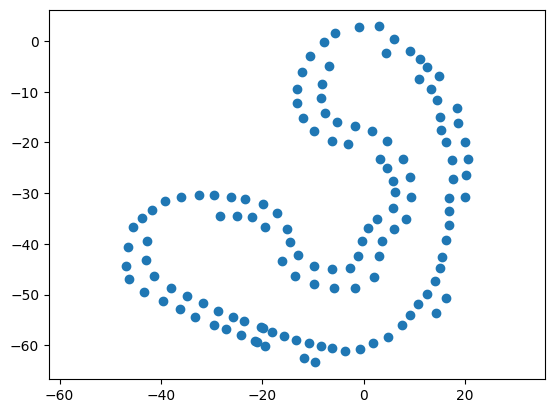

In [273]:
cones_relative = rotate(cones_together - position, -angle_from_2d_vector(direction))

plt.plot(*cones_relative.T, "o")
plt.axis("equal")

In [274]:
from fsd_path_planning.sorting_cones.trace_sorter.core_trace_sorter import TraceSorter
from fsd_path_planning.utils.cone_types import ConeTypes

In [275]:
ts_kwargs = dict(
    max_n_neighbors=5, max_dist=6.0, max_dist_to_first=6.0, max_length=10, threshold_directional_angle=np.deg2rad(40), threshold_absolute_angle=np.deg2rad(55)
)

ts = TraceSorter(**ts_kwargs)

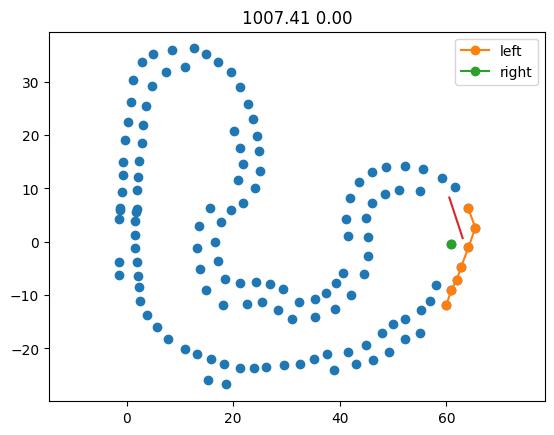

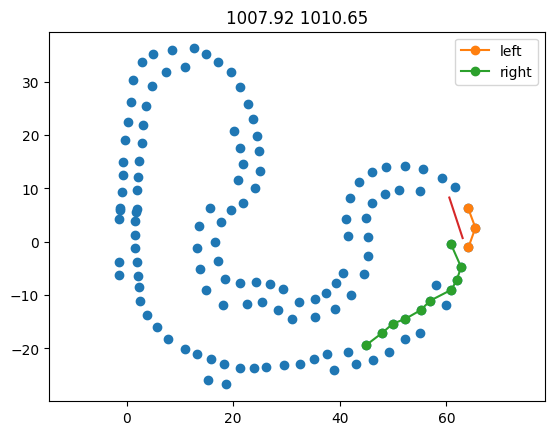

In [276]:
from fsd_path_planning.sorting_cones.trace_sorter.cost_function import cost_configurations


sort_order = [[ConeTypes.LEFT, ConeTypes.RIGHT], [ConeTypes.RIGHT, ConeTypes.LEFT]]

results = []

for first, second in sort_order:
    points_first, indices_first = ts.sort(cones_together, first, position, direction)

    mask_is_not_in_first = np.ones(len(cones_together), dtype=bool)
    mask_is_not_in_first[indices_first] = False

    cones_together_for_second = cones_together[mask_is_not_in_first]

    points_second, indices_second = ts.sort(cones_together_for_second, second, position, direction)

    left_points = points_first if first == ConeTypes.LEFT else points_second
    right_points = points_second if second == ConeTypes.RIGHT else points_first

    cost_left = cost_configurations(left_points, np.arange(len(left_points))[None], ConeTypes.LEFT, position, direction, return_individual_costs=False)
    cost_right = cost_configurations(right_points, np.arange(len(right_points))[None], ConeTypes.RIGHT, position, direction, return_individual_costs=False)


    car_start = position - direction * 4
    car_end = position + direction * 4
    car = np.array([car_start, car_end])

    plt.plot(*cones_together.T, "o")
    plt.plot(*left_points.T, "o-", label="left")
    plt.plot(*right_points.T, "o-", label="right")
    plt.title(f"{cost_left[0]:.2f} {cost_right[0]:.2f}")
    plt.plot(*car.T, "-")
    plt.legend()
    plt.axis("equal")
    plt.show()


    results.append((left_points, right_points, position, direction))
    


In [277]:
from fsd_path_planning.sorting_cones.trace_sorter.line_segment_intersection import pairwise_segment_intersection, number_of_intersections

def combined_score_of_traces(trace_left: np.ndarray, trace_right: np.ndarray, position: np.ndarray, direction: np.ndarray):
    
    cost_left = cost_configurations(trace_left, np.arange(len(trace_left))[None], ConeTypes.LEFT, position, direction, return_individual_costs=False)[0]
    cost_right = cost_configurations(trace_right, np.arange(len(trace_right))[None], ConeTypes.RIGHT, position, direction, return_individual_costs=False)[0]

    if len(trace_left) == 1 or len(trace_right) == 1:
        n = 0
    else:

        starts = np.row_stack([trace_left[:-1], trace_right[:-1]])
        ends = np.row_stack([trace_left[1:], trace_right[1:]])

        n_intersections_ignore = len(trace_left) - 2 + len(trace_right) - 2
        raw_intersections = pairwise_segment_intersection(starts, ends)

        n = number_of_intersections(raw_intersections) - n_intersections_ignore
    
    if 0 in (cost_left, cost_right):
        score = max(cost_left, cost_right)
    else:
        score = (cost_left + cost_right) / 2

    return_value = (n, -(len(trace_left) + len(trace_right)), score)
    return return_value


left_cones, right_cones, *_ = min(results, key=lambda x: combined_score_of_traces(*x))
    

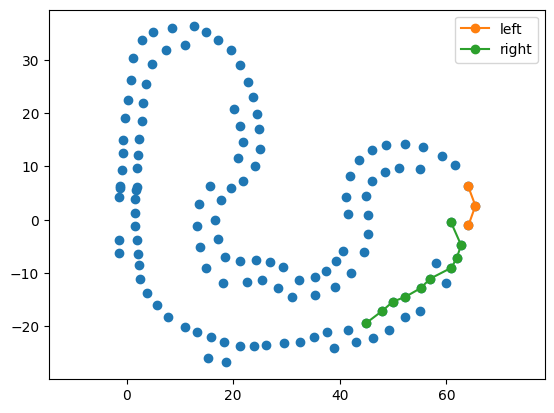

In [278]:
plt.plot(*cones_together.T, "o")
plt.plot(*left_cones.T, "o-", label="left")
plt.plot(*right_cones.T, "o-", label="right")
plt.axis("equal")
plt.legend()

In [257]:
def coloress_sorting(all_cones: np.ndarray, position: np.ndarray, direction: np.ndarray, is_final_run: bool=False) -> tuple[np.ndarray, np.ndarray]:
    """
    Sorts the cones into left and right cones. The first cone is always the left cone.
    :param all_cones: The cones to sort
    :param position: The position of the car
    :param direction: The direction of the car
    :return: The left and right cones
    """

    ts_kwargs_copy = ts_kwargs.copy()
    if is_final_run:
        ts_kwargs_copy["max_length"] = 10

    ts = TraceSorter(**ts_kwargs_copy)

    sort_order = [[ConeTypes.LEFT, ConeTypes.RIGHT], [ConeTypes.RIGHT, ConeTypes.LEFT]]

    results = []

    for first, second in sort_order:
        points_first, indices_first = ts.sort(all_cones, first, position, direction)

        mask_is_not_in_first = np.ones(len(all_cones), dtype=bool)
        mask_is_not_in_first[indices_first] = False

        cones_together_for_second = all_cones[mask_is_not_in_first]

        points_second, indices_second = ts.sort(cones_together_for_second, second, position, direction)

        left_points, right_points = (points_first, points_second)
        if first == ConeTypes.RIGHT:
            left_points, right_points = (points_second, points_first)
        

        results.append((left_points, right_points))

        if is_final_run and 0:
            plt.plot(*all_cones.T, "o")
            plt.plot(*left_points.T, "o-", label="left")
            plt.plot(*right_points.T, "o-", label="right")
            plt.plot([position[0], position[0] + direction[0] * 2], [position[1], position[1] + direction[1] * 2], "-")
            plt.legend()
            plt.axis("equal")
            plt.show()

    # scores = [combined_score_of_traces(*x) for x in results]
    # print(scores)
    left_cones, right_cones = min(results, key=lambda x: combined_score_of_traces(*x, position=position, direction=direction))

    # if not is_final_run and len(left_cones) > 1 and len(right_cones) > 1:
    #     return coloress_sorting(np.row_stack([left_cones, right_cones]), position, direction, is_final_run=True)
    
    
    return left_cones, right_cones

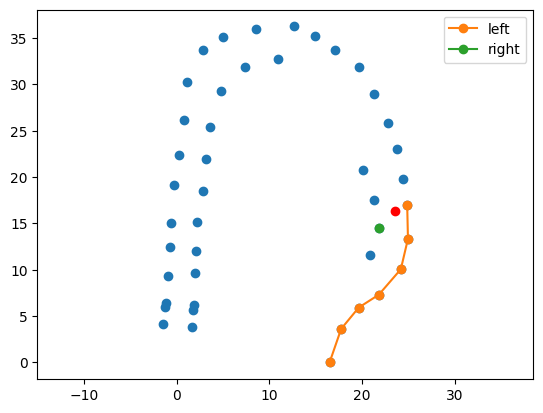

In [258]:


left_cones, right_cones = coloress_sorting(cones_together, position, direction)

plt.plot(*cones_together.T, "o")
plt.plot(*position, "ro")
plt.plot(*left_cones.T, "o-", label="left")
plt.plot(*right_cones.T, "o-", label="right")
plt.axis("equal")
plt.legend()

In [242]:
from fsd_path_planning.demo.json_demo import load_data_json
from tqdm import tqdm

demo_positions, demo_directions, demo_cones = load_data_json()

it = list(enumerate(zip(demo_positions, demo_directions, demo_cones)))

for i, (demo_positions_i, demo_directions_i, demo_cones_i) in tqdm(it):
    demo_cones_i = [np.array(cones_of_type).reshape(-1,2) for cones_of_type in demo_cones_i]
    cones_together = np.row_stack(demo_cones_i)

    left_cones, right_cones = coloress_sorting(cones_together, demo_positions_i, demo_directions_i)

    plt.plot(*cones_together.T, "o")
    plt.plot(*demo_positions_i, "ro")
    plt.plot(*left_cones.T, "o-", label="left")
    plt.plot(*right_cones.T, "o-", label="right")
    plt.axis("equal")
    plt.title(f"{i}")
    plt.savefig(f"frames/frame_{i:04d}.png")
    plt.close()
    # plt.show()

100%|██████████| 440/440 [02:38<00:00,  2.77it/s]


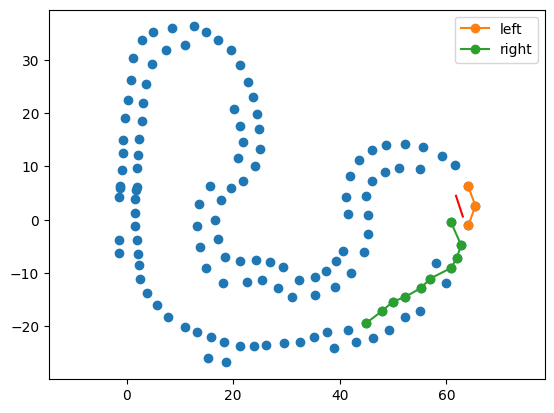

In [280]:
from fsd_path_planning.utils.math_utils import normalize

# important indices: 96, 70, 328, 191, 118, 182

_, (pos, dir_, cones) = it[182]

pos_end = pos + normalize(dir_) * 4.1

all_cones = np.row_stack([np.array(c).reshape(-1,2) for c in cones])

left_cones, right_cones = coloress_sorting(all_cones, pos, dir_)

plt.plot(*all_cones.T, "o")
plt.plot([pos[0], pos_end[0]],[pos[1], pos_end[1]], "r-")

plt.plot(*left_cones.T, "o-", label="left")
plt.plot(*right_cones.T, "o-", label="right")
plt.axis("equal")
plt.legend()

In [13]:
z = np.arange(10).reshape(-1,2)

np.diff(z, axis=0), z[1:] - z[:-1]

(array([[2, 2],
        [2, 2],
        [2, 2],
        [2, 2]]),
 array([[2, 2],
        [2, 2],
        [2, 2],
        [2, 2]]))

In [268]:
print(repr(it[182][1]))

(array([61.79275513,  4.48931885]), array([ 0.31248537, -0.94992257]), [array([], dtype=float64), array([[  2.06137085,  12.06208801],
       [  2.24887085,  15.12458801],
       [  1.62387085,   3.81208801],
       [  2.81137085,  18.49958801],
       [  1.99887085,   9.62458801],
       [  3.12387085,  21.93708801],
       [  3.56137085,  25.37458801],
       [  4.81137085,  29.24958801],
       [  7.37387085,  31.87458801],
       [ 10.91782737,  32.70692137],
       [ 21.24887085,  17.49958801],
       [ 21.88205023,  14.49969913],
       [ 20.13978407,  20.73465422],
       [ 20.87387085,  11.56208801],
       [ 13.27945776,  -1.18799202],
       [ 13.49887085,   2.87458801],
       [ 13.68637085,  -5.18791199],
       [ 15.62387085,   6.24958801],
       [ 14.93637085,  -9.06291199],
       [  1.56137085,   1.24958801],
       [  1.93637085,  -3.87541199],
       [  1.62387085,  -1.18791199],
       [  2.06137085,  -6.37541199],
       [  2.31137085,  -8.56291199],
       [  2.49